In [132]:
from copy import deepcopy
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [133]:
import torch, numpy as np
from minai.core import *
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch import nn, tensor
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [134]:
set_seed(42)

## Prepare

In [135]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
m = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=0,
    # use_flash_attention_2=True,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [136]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [137]:
# dataset_name = "cerebras/SlimPajama-627B"
dataset_name = "roneneldan/TinyStories"

In [138]:
dataset = load_dataset(dataset_name)

Repo card metadata block was not found. Setting CardData to empty.


In [139]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [140]:
def tok(x):
    x = tokenizer(x['text'], padding='longest')
    x['labels'] = deepcopy(x['input_ids'])
    return x

In [141]:
lf = nn.CrossEntropyLoss()

In [142]:
dataset = dataset.shuffle(42).filter(lambda x:len(x['text'])<1024)

Filter:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [143]:
train_dataset = dataset["train"] # Subset for testing
eval_dataset = dataset["validation"] # And only 200 eval samples
train_dataset

Dataset({
    features: ['text'],
    num_rows: 1694892
})

In [144]:
# Reorder by length

In [145]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [146]:
batch_size = 16

In [147]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

In [148]:
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [149]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([16, 275]), torch.Size([16, 275]))

In [150]:
tokenizer.decode(xb[0])[:250]

"<s> Once there was a little girl who was very intelligent. Her family wanted her to lead the way. So they sent her out on a journey.\n\nThe little girl came across something purple. She wanted to pick it up, but she didn't know what it was. She asked a"

In [151]:
tokenizer.decode(yb[0])[:250]

"Once there was a little girl who was very intelligent. Her family wanted her to lead the way. So they sent her out on a journey.\n\nThe little girl came across something purple. She wanted to pick it up, but she didn't know what it was. She asked a nea"

## Training

In [152]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [153]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [154]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1,
#     target_modules=[l+"_proj" for l in ["k", 'v', "q", "o", "gate", "up", "down"]]
# )
# m = get_peft_model(m, peft_config)

In [156]:
from torcheval.metrics import MulticlassAccuracy

In [319]:
from minai.core import _get_preds

class HFMetricsCB(MetricsCB):
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): 
            preds = _get_preds(learn.preds, learn.preds_nm) # torcheval is not compatible with dicts
            classes = preds.shape[-1]  #torcheval wants flatten tensors
            m.update(to_cpu(preds).view(-1, classes), y.view(-1))
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [320]:
import wandb

class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): self.model_name = model_name
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
    
    def after_batch(self, learn):
        m =  {k:v.compute().item() for k,v in learn.metrics.all_metrics.items()}
        if learn.training:    
            m["train_loss"] = m["loss"]
        else: m["val_loss"] = m["loss"]
        m.pop("loss", None)
        wandb.log(m)
            
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [155]:
from torch import optim

In [309]:
prog = ProgressCB(plot=True)
cbs = [DeviceCB(), 
       HFMetricsCB(accuracy=MulticlassAccuracy(num_classes=tokenizer.vocab_size))]

In [310]:
# Just freeze embeddings for small memory decrease
m.model.embed_tokens.weight.requires_grad_(False);

## Splitting the model

In [326]:
cut = 24
m.model.layers = m.model.layers[:cut]

In [327]:
m

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-23): 24 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_

In [328]:
n_freeze = 24
for param in m.parameters(): param.requires_grad = False
for param in m.lm_head.parameters(): param.requires_grad = True
for param in m.model.layers[n_freeze:].parameters(): param.requires_grad = True

In [329]:
from functools import partial
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [330]:
lr = 1e-3
sz = len(dls.train)//50

In [331]:
cb_trn = TrainCB(preds_nm='logits')
learn = MomentumLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz, mom=0.9)
# learn = TrainLearner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs, preds_nm='logits', epoch_sz=sz)
# learn = Learner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[cb_trn], epoch_sz=sz) #, opt_func=optim)

In [332]:
m.gradient_checkpointing_enable()

In [333]:
# NB lr_find does *not* reset model, so recreate it afterwards
# learn.lr_find(max_mult=10)

In [334]:
wandb.init(project="miniai_llm")

accuracy,▄▁▃▅▃▃▅▆▅▇███▇▇▇
loss,▃█▇▄▇▇▅▄▄▂▁▁▁▂▂▂
accuracy,0.75263
loss,0.93574


/opt/conda/envs/pt/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


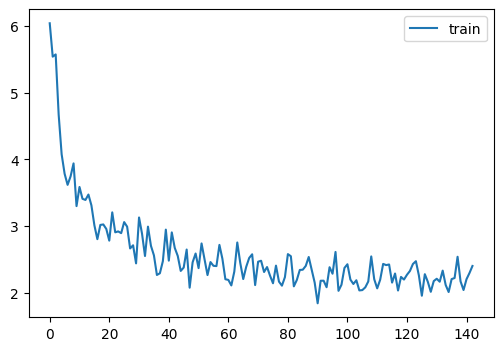

In [ ]:
learn.fit(1, cbs=[prog, WandbCB()])

In [ ]:
wandb.finish()

## Testing

In [ ]:
prompt = "Context:" + eval_dataset[0]['context'] + "\nQuestion:" + eval_dataset[0]['question'] + "\nAnswer:"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()

In [ ]:
with torch.inference_mode():
    output = model.generate(tokenized_prompt, max_new_tokens=90)

In [ ]:
print(prompt + tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True))

Context:CREATE TABLE table_name_95 (tournament VARCHAR, score VARCHAR, outcome VARCHAR, surface VARCHAR)
Question:Which tournament has an Outcome of runner-up, a Surface of hard, and a Score of 6–4, 6–2?
Answer:SELECT tournament FROM table_name_95 WHERE outcome = "runner-up" AND surface = "hard" AND score = "6–4, 6–2"


## fin -